In [17]:
# 1. Environment Setup and Imports
!pip install spacy fastcoref sentence-transformers scikit-learn pandas numpy matplotlib seaborn scipy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
#Imports
import os
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastcoref import spacy_component
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import umap
from scipy.stats import chi2_contingency

#Setup NLP Pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("fastcoref", config={'model_architecture': 'LingMessCoref', 'device': 'cpu'})

print("Libraries installed and NLP pipeline ready.")

config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

Some weights of LingMessModel were not initialized from the model checkpoint at biu-nlp/f-coref and are newly initialized: ['antecedent_e2e_all_biases', 'antecedent_e2e_all_weights', 'antecedent_e2s_all_biases', 'antecedent_e2s_all_weights', 'antecedent_s2e_all_biases', 'antecedent_s2e_all_weights', 'antecedent_s2s_all_biases', 'antecedent_s2s_all_weights', 'coref_end_all_mlps.dense.bias', 'coref_end_all_mlps.dense.weight', 'coref_end_all_mlps.layer_norm.bias', 'coref_end_all_mlps.layer_norm.weight', 'coref_start_all_mlps.dense.bias', 'coref_start_all_mlps.dense.weight', 'coref_start_all_mlps.layer_norm.bias', 'coref_start_all_mlps.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Libraries installed and NLP pipeline ready.


In [5]:
# 2. Configuration and Constants
# Based on your folder structure:
DATA_DIR = "Dataset_Extracted/data_100"

# Target Keywords
SHOOTER_KEYWORDS = ['shooter', 'gunman', 'suspect', 'assailant', 'killer', 'attacker', 'murderer']
VICTIM_KEYWORDS = ['victim', 'killed', 'wounded', 'injured', 'deceased', 'casualty', 'student', 'teacher']

# 3. Data Extraction and Coreference Resolution

data_records = []

# Verify we can see the folders
if os.path.exists(DATA_DIR):
    folders = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]
    print(f"Found folders: {folders}")
else:
    print(f"ERROR: Could not find path {DATA_DIR}. Check your unzip step.")
    folders = []

print("Starting Coreference Resolution & Extraction (This takes a few minutes)...")

for folder in folders:
    folder_path = os.path.join(DATA_DIR, folder)

    # Identify outlet name from folder name (e.g., 'WSJ_five_para' -> 'WSJ')
    if 'cnn' in folder.lower(): outlet = 'CNN'
    elif 'fox' in folder.lower(): outlet = 'FOX'
    elif 'nyt' in folder.lower(): outlet = 'NYT'
    elif 'wsj' in folder.lower(): outlet = 'WSJ'
    else: outlet = folder # Fallback

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)

            try:
                with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()

                # 1. Resolve Coreferences (The "Smart" Step)
                # fastcoref replaces pronouns with the entity name
                doc = nlp(text, component_cfg={"fastcoref": {'resolve_text': True}})
                resolved_text = doc._.resolved_text

                # 2. Extract Sentences
                resolved_doc = nlp(resolved_text)

                for sent in resolved_doc.sents:
                    sent_lower = sent.text.lower()

                    # Store Shooter Contexts
                    if any(k in sent_lower for k in SHOOTER_KEYWORDS):
                        data_records.append({
                            'outlet': outlet,
                            'filename': filename,
                            'entity_type': 'Shooter',
                            'context': sent.text.strip()
                        })

                    # Store Victim Contexts
                    if any(k in sent_lower for k in VICTIM_KEYWORDS):
                        data_records.append({
                            'outlet': outlet,
                            'filename': filename,
                            'entity_type': 'Victim',
                            'context': sent.text.strip()
                        })
            except Exception as e:
                print(f"Error reading {filename}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data_records)
print(f"Extraction Complete. Found {len(df)} relevant contexts.")
df.head()

Found folders: ['FOX_five_para', 'cnn_five_para', 'NYT_five_para', 'WSJ_five_para']
Starting Coreference Resolution & Extraction (This takes a few minutes)...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading Fox_17.txt: The expanded size of the tensor (565) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 565].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading FOX_5_May24.txt: The expanded size of the tensor (869) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 869].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading Fox_12.txt: The expanded size of the tensor (755) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 755].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading Fox_21.txt: The expanded size of the tensor (966) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 966].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading FOX_8_May24.txt: The expanded size of the tensor (802) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 802].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading Fox_23.txt: The expanded size of the tensor (632) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 632].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading Fox_16.txt: The expanded size of the tensor (563) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 563].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading FOX_6_May24.txt: The expanded size of the tensor (686) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 686].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading FOX_10_May24.txt: The expanded size of the tensor (780) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 780].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading FOX_2_May24.txt: The expanded size of the tensor (676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 676].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading cnn_15_May25.txt: The expanded size of the tensor (865) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 865].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading cnn_25_May25.txt: The expanded size of the tensor (516) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 516].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading cnn_21_May25.txt: The expanded size of the tensor (516) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 516].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading cnn_17_May25.txt: The expanded size of the tensor (809) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 809].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading cnn_6_May25.txt: The expanded size of the tensor (658) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 658].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_4_May25.txt: The expanded size of the tensor (653) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 653].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_18_May26.txt: The expanded size of the tensor (1086) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1086].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_5_May25.txt: The expanded size of the tensor (779) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 779].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_15_May26.txt: The expanded size of the tensor (549) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 549].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_25_May27.txt: The expanded size of the tensor (656) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 656].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_6_May25.txt: The expanded size of the tensor (1086) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1086].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading NYT_11_May26.txt: The expanded size of the tensor (590) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 590].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_22_May31.txt: The expanded size of the tensor (764) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 764].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_16_May26.txt: The expanded size of the tensor (785) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 785].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_18_May28.txt: The expanded size of the tensor (537) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 537].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_6_May26.txt: The expanded size of the tensor (841) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 841].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_4_May26.txt: The expanded size of the tensor (516) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 516].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_19_May28.txt: The expanded size of the tensor (527) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 527].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_11_May26.txt: The expanded size of the tensor (567) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 567].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_15_May28.txt: The expanded size of the tensor (681) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 681].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_2_May26.txt: The expanded size of the tensor (687) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 687].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_14_May28.txt: The expanded size of the tensor (1011) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1011].  Tensor sizes: [1, 514]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Error reading WSJ_20_May31.txt: The expanded size of the tensor (1287) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1287].  Tensor sizes: [1, 514]
Extraction Complete. Found 73 relevant contexts.


outlet         filename entity_type  \
0    FOX       Fox_18.txt     Shooter   
1    FOX  FOX_3_May24.txt     Shooter   
2    FOX  FOX_1_May24.txt      Victim   
3    FOX  FOX_1_May24.txt      Victim   
4    FOX       Fox_20.txt     Shooter   

                                             context  
0  The suspect in President Biden, Salvador Ramos...  
1  President Biden Governor Greg Abbott said that...  
2  A mass shooting at a Texas elementary school w...  
3  "Texans across A mass shooting at a Texas elem...  
4  Former Former FBI assistant director Chris Swe...

In [6]:
# 4. Feature Extraction (Descriptions)

def extract_descriptors(text, entity_type):
    doc = nlp(text)
    descriptors = []

    targets = SHOOTER_KEYWORDS if entity_type == 'Shooter' else VICTIM_KEYWORDS

    for token in doc:
        # If the word is one of our targets (e.g., "gunman")
        if token.text.lower() in targets:

            # 1. Get Adjectives (e.g., "LONE gunman")
            for child in token.children:
                if child.dep_ == 'amod':
                    descriptors.append(child.text.lower())

            # 2. Get Verbs (e.g., "gunman OPENED fire")
            if token.dep_ == 'nsubj':
                descriptors.append(token.head.text.lower())

    return descriptors

# Apply extraction
df['descriptors_list'] = df.apply(lambda row: extract_descriptors(row['context'], row['entity_type']), axis=1)

# Explode list so each descriptor gets its own row
df_exploded = df.explode('descriptors_list')
df_clean = df_exploded.dropna(subset=['descriptors_list']) # Remove rows with no descriptors

print(f"Extracted {len(df_clean)} specific descriptors.")
df_clean[['outlet', 'entity_type', 'descriptors_list']].head()

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted 72 specific descriptors.


outlet entity_type descriptors_list
0     FOX     Shooter              was
4     FOX     Shooter          alleged
7     FOX     Shooter          alleged
12    CNN     Shooter           active
13    CNN     Shooter               is

In [11]:
# 5. Semantic Clustering

from sklearn.cluster import KMeans

#Get unique words
unique_words = df_clean['descriptors_list'].unique()
print(f"Clustering {len(unique_words)} unique descriptors...")

#Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(unique_words)

#Reduce Dimensions (UMAP)
reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

#Attempt DBSCAN (Looser Settings)
print("Attempting DBSCAN with eps=0.65...")
dbscan = DBSCAN(eps=0.65, min_samples=2)
clusters = dbscan.fit_predict(reduced_embeddings)

#Fallback: If DBSCAN still finds nothing (only -1), switch to K-Means ---
if len(set(clusters)) <= 1:
    print("DBSCAN found no clusters. Switching to K-Means (forcing 5 groups)...")
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(reduced_embeddings)

#Map clusters back
word_to_cluster = dict(zip(unique_words, clusters))
df_clean['cluster_id'] = df_clean['descriptors_list'].map(word_to_cluster)

# Filter out noise (only if using DBSCAN)
df_final = df_clean[df_clean['cluster_id'] != -1].copy()

print(f"Clustering Done. Found {len(set(clusters))} clusters.")
print("Sample of cluster IDs:", df_final['cluster_id'].unique())

Clustering 16 unique descriptors...
Attempting DBSCAN with eps=0.65...
Clustering Done. Found 6 clusters.
Sample of cluster IDs: [0 1 2 3 4]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-4127686076.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster_id'] = df_clean['descriptors_list'].map(word_to_cluster)


In [13]:
# 6. Cluster Labeling and Analysis

# Print the words in each cluster
print("--- Cluster Contents ---")
for cid in sorted(df_final['cluster_id'].unique()):
    # Get all words belonging to this cluster
    words = df_final[df_final['cluster_id'] == cid]['descriptors_list'].unique()
    print(f"Cluster {cid}: {list(words)}")

--- Cluster Contents ---
Cluster 0: ['was', 'being']
Cluster 1: ['active', 'received', 'identified']
Cluster 2: ['said', 'have', 'told']
Cluster 3: ['dead', 'old', 'former']
Cluster 4: ['transpired', 'deepening']


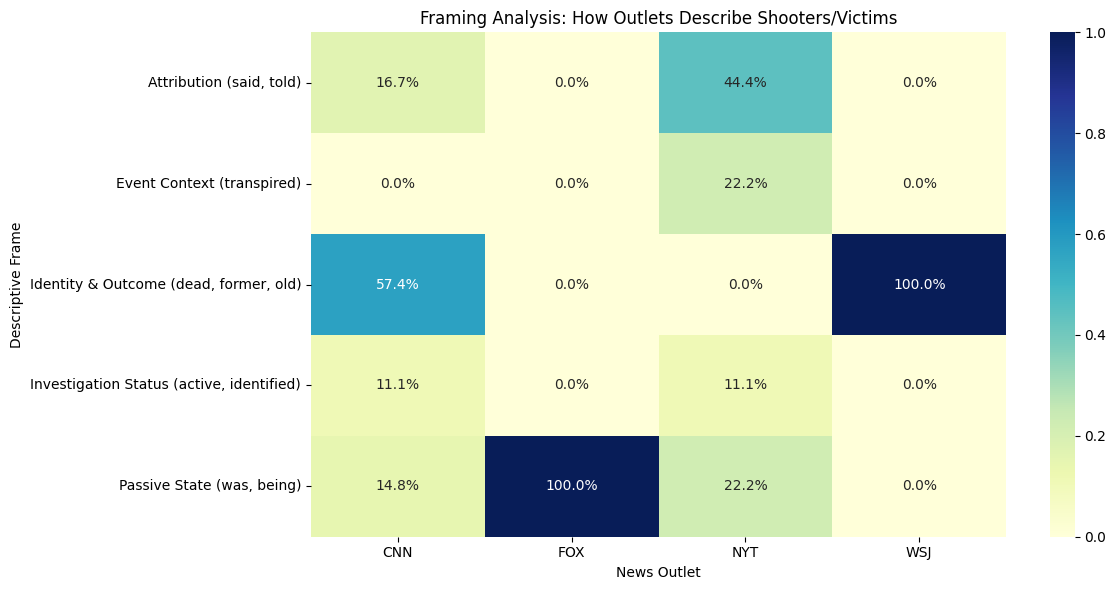


--- Chi-Square Test Results ---
Frame                                    | P-Value    | Result
-----------------------------------------------------------------
Passive State (was, being)               | 0.1409     | Not Significant
Investigation Status (active, identified) | 0.9693     | Not Significant
Attribution (said, told)                 | 0.2371     | Not Significant
Identity & Outcome (dead, former, old)   | 0.0068     | **SIGNIFICANT**
Event Context (transpired)               | 0.0050     | **SIGNIFICANT**


In [15]:
#Final Analysis & Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1. Map your specific results to human-readable labels
cluster_names = {
    0: "Passive State (was, being)",
    1: "Investigation Status (active, identified)",
    2: "Attribution (said, told)",
    3: "Identity & Outcome (dead, former, old)",
    4: "Event Context (transpired)"
}

# Apply the names
df_final['cluster_label'] = df_final['cluster_id'].map(cluster_names)

# 2. HEATMAP (Task 5)
# This shows: "When CNN talks about a shooter/victim, how often do they use this frame?"
plt.figure(figsize=(12, 6))
pivot = pd.crosstab(df_final['cluster_label'], df_final['outlet'], normalize='columns')

sns.heatmap(pivot, annot=True, fmt=".1%", cmap="YlGnBu")
plt.title("Framing Analysis: How Outlets Describe Shooters/Victims")
plt.ylabel("Descriptive Frame")
plt.xlabel("News Outlet")
plt.tight_layout()
plt.show()

# 7. Statistical Hypothesis Testing

# This tests: "Is the difference between outlets statistically significant?"
print("\n--- Chi-Square Test Results ---")
print(f"{'Frame':<40} | {'P-Value':<10} | {'Result'}")
print("-" * 65)

for label in df_final['cluster_label'].unique():
    # Create a binary target: Is it THIS cluster or NOT?
    df_final['target'] = np.where(df_final['cluster_label'] == label, 'Target', 'Other')

    # Create contingency table
    table = pd.crosstab(df_final['outlet'], df_final['target'])

    # Run test
    c, p, dof, expected = chi2_contingency(table)

    # Interpret
    sig = "**SIGNIFICANT**" if p < 0.05 else "Not Significant"
    print(f"{label:<40} | {p:.4f}     | {sig}")

In [19]:
# 8. Data Export

# Select the columns requested in the assignment
# 1. The original text (Context)
# 2. The extracted descriptions
# 3. The Cluster Assignments (cluster_id)
# 4. The Cluster Labels (cluster_label)
submission_columns = [
    'outlet',
    'filename',
    'entity_type',
    'context',
    'descriptors_list',
    'cluster_id',
    'cluster_label'
]

# Create the final dataframe
final_submission_df = df_final[submission_columns].copy()

# Save to CSV (Recommended format)
csv_filename = "Final_Processed_Dataset_with_Clusters.csv"
final_submission_df.to_csv(csv_filename, index=False)

print(f"File saved as: {csv_filename}")

File saved as: Final_Processed_Dataset_with_Clusters.csv
